# ***Needed Functions***

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.applications import ResNet50V2
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from functools import partial
from typing import Union
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import logging as log



def visualize(ds, grid_size=(1,1), pdf_name:Union[str, None]=None):
    """
    Visualize the first n samples of the dataset. If grid_size has 0, nothing is done.

    Args:
        ds (tf.data.Dataset): Dataset to visualize.
        grid_size (tuple, optional): Size of the grid to plot the samples. Defaults to (1,1).
        pdf_name (str, optional): Name of the pdf file to save the plot. Defaults to None.
    """
    
    if 0 in grid_size:
        return
    
    n = grid_size[0] * grid_size[1]

    plt.figure(figsize=(12, 12))
    for i, (X, y) in enumerate(ds.take(n)):
        image = X
        label = y
        plt.subplot(*grid_size, i+1)
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.imshow(image)
    if pdf_name:
        plt.savefig(pdf_name)
    plt.show()


def filter_fn(example, chosen_labels_ids):
    """
    Filters the dataset to only include the chosen labels.

    Args:
        example (dict): Dictionary containing the image and the labels.
        chosen_labels_ids (list): List of the chosen labels ids in cifar10 dataset.

    Returns:
        bool: True if the example contains one of the chosen labels, False otherwise.
    """

    labels = example["label"]
    flags = [tf.reduce_any(tf.equal(labels, label)) for label in chosen_labels_ids]
    return tf.reduce_any(flags)

def preprocess_fn(example, chosen_labels_ids):
    """
    Preprocess the dataset to resize the images to 224x224 and normalize the pixel values.
    It also converts the original cifar10 label ids to new ids starting from 0.

    Args:
        example (dict): Dictionary containing the image and the labels.
        chosen_labels_ids (list): List of the chosen labels ids in cofar10 dataset.

    Returns:
        tuple: Tuple containing the preprocessed image and the new label id.
    """
    image = example['image']
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image /= 255.0
    labels = example['label']
    label = [tf.reduce_any(tf.equal(labels, label)) for label in chosen_labels_ids]
    label = tf.cast(label, tf.int32)
    label = tf.argmax(label)
    return image, label

def createModel(n_classes=10):
    """
    Creates a model with ResNet50V2 as base model and two dense layers on top.

    Args:
        n_classes (int, optional): Number of classes. Defaults to 2.

    Returns:
        tf.keras.Model: Model with ResNet50V2 as base model and two dense layers on top.
    # """

    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def generateDataset(n_teacher=1000, n_labeled=1000, n_unlabeled=10000, classes=('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')):
    """
    Generates the dataset for the experiment. Here we filter the dataset to only include the chosen labels.
    We also preprocess the dataset to resize the images to 224x224 and normalize the pixel values.

    Args:
        n_teacher (int, optional): Number of samples for the teacher model initial training. Defaults to 1000.
        n_labeled (int, optional): Number of labeled samples for the student model training. Defaults to 1000.
        n_unlabeled (int, optional): Number of unlabeled samples for the student model training. Defaults to 10000.

    Returns:
        tuple: Tuple containing the teacher dataset, the labeled dataset and the unlabeled dataset.
    """
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
    (ds_train, _, __), ds_info = tfds.load('cifar10', split=split, with_info=True)

    cifar10_labels = ds_info.features["label"].names
    chosen_labels_ids = [cifar10_labels.index(label) for label in classes]
    ds_train = ds_train.filter(lambda x: partial(filter_fn, chosen_labels_ids=chosen_labels_ids)(x))
    ds_train = ds_train.map(lambda x: partial(preprocess_fn, chosen_labels_ids=chosen_labels_ids)(x))
    ds_train_teacher = ds_train.take(n_teacher)
    ds_train = ds_train.skip(n_teacher)
    N = n_labeled + n_unlabeled
    ds_train = ds_train.take(N)
    ds_train_labeled = ds_train.take(n_labeled)
    ds_train_unlabeled = ds_train.skip(n_labeled)
    return ds_train_teacher, ds_train_labeled, ds_train_unlabeled



# ***Create and save teacher's model***

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL75PD5/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL75PD5/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


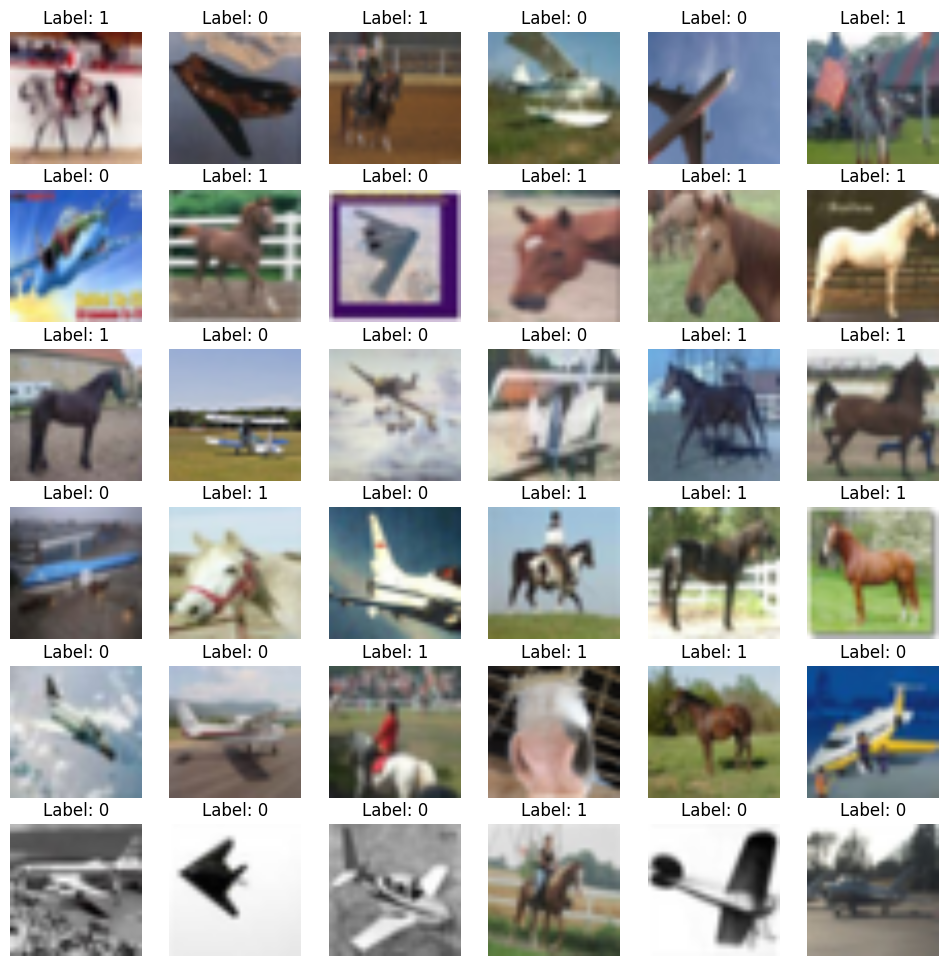

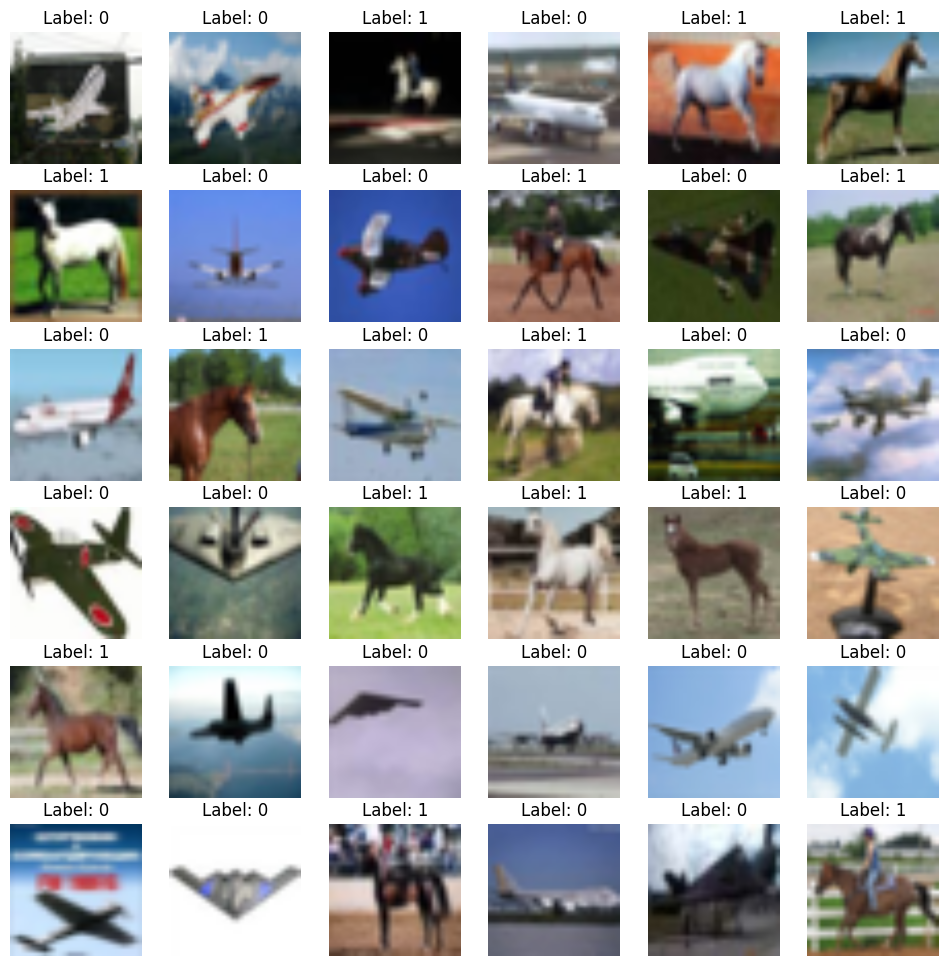

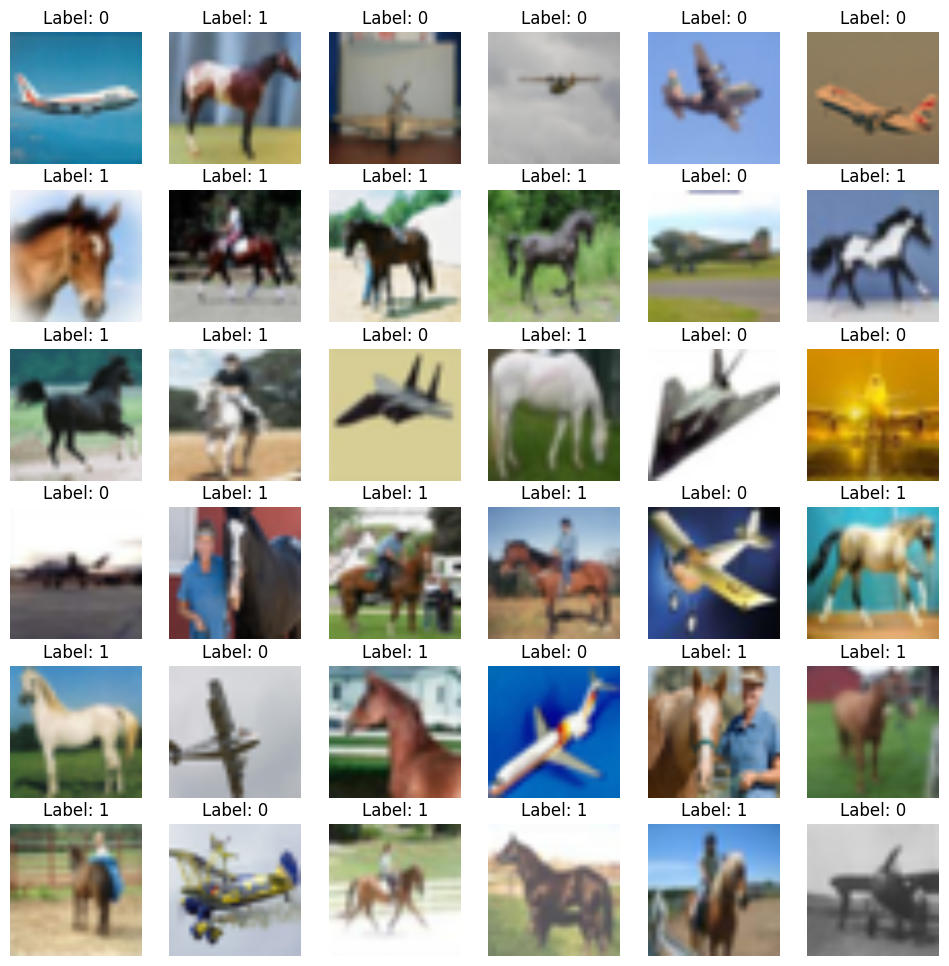

In [2]:
# classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')
classes = 'airplane', 'horse'
n_teacher = 1000
n_labeled = 1000
n_unlabeled = 10000
ds_train_teacher, ds_train_labeled, ds_train_unlabeled = generateDataset(n_teacher, n_labeled, n_unlabeled, classes)
epochs = 5
batch_size = 32

#  Visualizing the data...
grid_size = (6, 6)
visualize(ds_train_teacher, grid_size, 'dataset.pdf')
visualize(ds_train_labeled, grid_size)
visualize(ds_train_unlabeled, grid_size)


94668760/94668760 [==============================] - 6s 0us/step
Epoch 1/5
32/32 [==============================] - 19s 250ms/step - loss: 0.3140 - accuracy: 0.8650 - val_loss: 0.1643 - val_accuracy: 0.9480
Epoch 2/5
32/32 [==============================] - 6s 181ms/step - loss: 0.1137 - accuracy: 0.9690 - val_loss: 0.1212 - val_accuracy: 0.9580
Epoch 3/5
32/32 [==============================] - 6s 187ms/step - loss: 0.0781 - accuracy: 0.9790 - val_loss: 0.1058 - val_accuracy: 0.9620
Epoch 4/5
32/32 [==============================] - 6s 182ms/step - loss: 0.0584 - accuracy: 0.9840 - val_loss: 0.0970 - val_accuracy: 0.9630
Epoch 5/5
32/32 [==============================] - 6s 188ms/step - loss: 0.0451 - accuracy: 0.9900 - val_loss: 0.0914 - val_accuracy: 0.9650


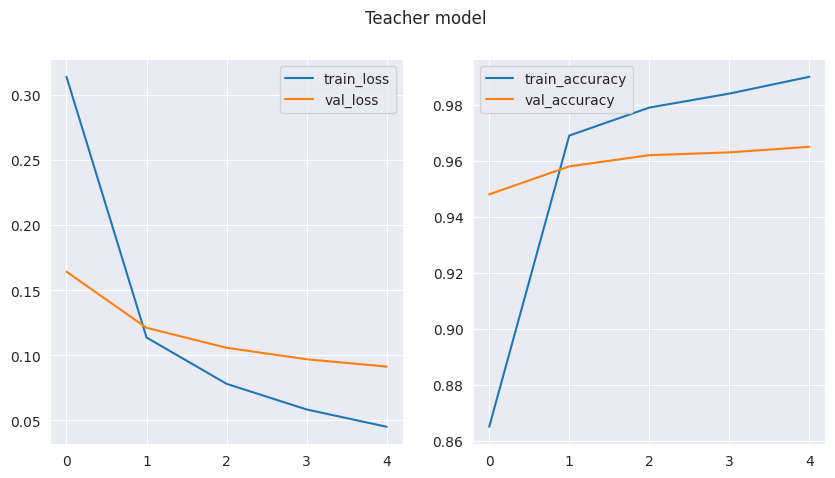

In [3]:
##  Teacher model...
epochs = 5
batch_size = 32
model_teacher = createModel(len(classes))
hist = model_teacher.fit(ds_train_teacher.batch(batch_size), epochs=epochs, validation_data=ds_train_labeled.batch(batch_size))
model_teacher.save('teacher')

##  Plotting training history...
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.suptitle('Teacher model')
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.savefig('teacher.pdf')
plt.show()

# ***Load teacher's model***

In [4]:
# classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')

# n_teacher = 1000
# n_labeled = 1000
# n_unlabeled = 10000
# ds_train_teacher, ds_train_labeled, ds_train_unlabeled = generateDataset(n_teacher, n_labeled, n_unlabeled, classes)
# epochs = 5


##  Teacher model...
# model_teacher = models.load_model('teacher')

# ***Student's model***

In [5]:
log.basicConfig(level=log.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

##  Student model...
model_student = createModel(len(classes))
opt_t = optimizers.Adam(learning_rate=0.0001)  ##  Teacher optimizer
opt_s = optimizers.Adam(learning_rate=0.0001)  ##  Student optimizer

hist = []
hist_t = []
acc_s = []
acc_t = []

def train_batch(model_t, model_s, Xl_batch, yl_batch, Xu_batch, iter):
  with tf.GradientTape(persistent=True) as gt1:
    new_vars = []
    gt1.watch(model_t.trainable_variables)
    gt1.watch(model_s.trainable_variables)
    with  tf.GradientTape(persistent=True) as gt2:
      gt2.watch(model_t.trainable_variables)
      gt2.watch(model_s.trainable_variables)
      pred_t = model_t(Xu_batch, training=True)
      pred_s = model_s(Xu_batch, training=True)
      log_pred_s = -tf.math.log(pred_s)
      loss_u = tf.math.reduce_mean(tf.math.multiply(pred_t, log_pred_s))
    grad_s = gt2.gradient(loss_u, model_s.trainable_variables)
    for grad, var in zip(grad_s, model_s.trainable_variables):
      new_vars.append(var - opt_s.learning_rate.numpy() * grad)
    opt_s.apply_gradients(zip(grad_s, model_s.trainable_variables))
    pred_l_s = model_s(Xl_batch)
    loss_l = losses.sparse_categorical_crossentropy(yl_batch, pred_l_s)
    pred_l_t = model_t(Xl_batch)
    loss_l_t = losses.sparse_categorical_crossentropy(yl_batch, pred_l_t)

    ## Calculate accuracy
    ac_s = tf.keras.metrics.sparse_categorical_accuracy(yl_batch, pred_l_s)
    ac_t = tf.keras.metrics.sparse_categorical_accuracy(yl_batch, pred_l_t)

  ##  Chain rule...
  grad_1 = gt1.gradient(loss_l, model_s.trainable_variables)
  grad_2 = gt1.gradient(new_vars, model_t.trainable_variables)
  grad_t = [tf.math.multiply(g1, g2) for (g1, g2) in zip(grad_1, grad_2)]
  opt_t.apply_gradients(zip(grad_t, model_t.trainable_variables))
  ##  Logging...
  print(f'Iteration {iter}: Student Loss: {loss_l.numpy().mean():6.4f}')
  hist.append(loss_l.numpy().mean())
  hist_t.append(loss_l_t.numpy().mean())
  acc_s.append(ac_s.numpy().mean())
  acc_t.append(ac_t.numpy().mean())
  
  return model_t, model_s

In [6]:
def train(model_t, model_s, ds_train_labeled, ds_train_unlabeled, n_epochs=10):
    ds_train_labeled = ds_train_labeled.batch(4)
    ds_train_unlabeled = ds_train_unlabeled.batch(4)
    for epoch in range(n_epochs):
        for iter, ((X_l, y_l), (X_u, _)) in enumerate(zip(ds_train_labeled, ds_train_unlabeled)):
            print(f'Epoch {epoch}, Iteration {iter}...')
            model_t, model_s = train_batch(model_t, model_s, X_l, y_l, X_u, iter)
    return model_t, model_s

In [7]:
model_teacher, model_student = train(model_teacher, model_student, ds_train_labeled, ds_train_unlabeled, n_epochs=2)

Epoch 0, Iteration 0...


Iteration 0: Student Loss: 0.5850
Epoch 0, Iteration 1...
Iteration 1: Student Loss: 2.7694
Epoch 0, Iteration 2...
Iteration 2: Student Loss: 0.6323
Epoch 0, Iteration 3...
Iteration 3: Student Loss: 0.7340
Epoch 0, Iteration 4...
Iteration 4: Student Loss: 0.6260
Epoch 0, Iteration 5...
Iteration 5: Student Loss: 1.1862
Epoch 0, Iteration 6...
Iteration 6: Student Loss: 0.6307
Epoch 0, Iteration 7...
Iteration 7: Student Loss: 0.6380
Epoch 0, Iteration 8...
Iteration 8: Student Loss: 0.5069
Epoch 0, Iteration 9...
Iteration 9: Student Loss: 0.6005
Epoch 0, Iteration 10...
Iteration 10: Student Loss: 0.5649
Epoch 0, Iteration 11...
Iteration 11: Student Loss: 0.6196
Epoch 0, Iteration 12...
Iteration 12: Student Loss: 0.5396
Epoch 0, Iteration 13...
Iteration 13: Student Loss: 0.2487
Epoch 0, Iteration 14...
Iteration 14: Student Loss: 0.6843
Epoch 0, Iteration 15...
Iteration 15: Student Loss: 0.3523
Epoch 0, Iteration 16...
Iteration 16: Student Loss: 0.1960
Epoch 0, Iteration 17...

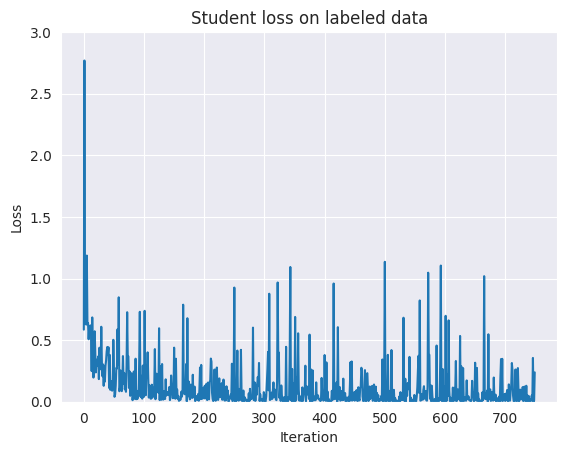

In [ ]:
plt.figure()
sns.set_style('darkgrid')
plt.plot(hist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Student loss on labeled data')
plt.ylim(0, 3)
plt.savefig('student_loss.pdf')

plt.show()

In [13]:
min(hist)

0.00041471238